In [1]:
%pdb off
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, os.path as op
import pandas as pd
import geopandas as gpd
from osgeo import gdal, ogr
import numpy as np
from pathlib import Path
from shapely.wkt import loads
from rasterio.crs import CRS
from ARIAtools.shapefile_util import open_shapefile

#Plotting
import contextily as cx
from matplotlib import pyplot as plt

#Dask
import dask
from dask.distributed import progress, Client

os.environ['USE_PYGEOS'] = '0'

print (os.getenv('CONDA_PROMPT_MODIFIER'), datetime.now().date())

use_small = True # use a small or large number of products


Automatic pdb calling has been turned OFF
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(ARIA)  2023-09-07


In [2]:
def open_shapefile(fname, lyrind, ftind):
    """Open a existing shapefile and pass the coordinates back."""
    # import dependencies
    from shapely.wkt import loads

    # opening the file
    file_bbox = ogr.Open(fname)

    #If layer name provided
    if isinstance(lyrind, str):
        file_bbox = file_bbox.GetLayerByName(lyrind).GetFeature(ftind)

    #If layer index provided
    else:
        file_bbox = file_bbox.GetLayerByIndex(lyrind).GetFeature(ftind)
    geom = file_bbox.GetGeometryRef()
    file_bbox = loads(geom.ExportToWkt())

    return file_bbox

# Function to quickly get all the layers
def get_nc_groups(filename_nc : str):
    from osgeo import gdal
    #open nc file
    ds = gdal.Open(filename_nc)
    metadata = ds.GetMetadata()

    # Get Groups
    groups_df = pd.DataFrame(columns=['LAYER','PATH'])
    for layer in ds.GetSubDatasets():
        layer_df = pd.DataFrame(data={'LAYER':[layer[0].split(':')[-1].split('/')[-1]],
                                       'PATH':[layer[0]]})
        groups_df = pd.concat([groups_df, layer_df], ignore_index=True)
    #close
    ds = None

    return groups_df, metadata


def ds_get_extent(gdal_ds):
    E = gdal_ds.GetGeoTransform()[0]
    W = gdal_ds.GetGeoTransform()[0] + gdal_ds.GetGeoTransform()[1] * gdal_ds.RasterXSize
    N = gdal_ds.GetGeoTransform()[3] 
    S = gdal_ds.GetGeoTransform()[3] + gdal_ds.GetGeoTransform()[5] * gdal_ds.RasterYSize
    return [E, W, S, N]

In [3]:
# select dirs
path_data = os.getenv('dataroot')
raid_dir  = 'Tests' if 'leffe' in path_data else 'Exps'

# Download

In [ ]:
import hyp3_sdk
import concurrent.futures
from tqdm import tqdm

job_name = 'track4-n3'
user_id = 'cmarshak'
hyp3_isce = hyp3_sdk.HyP3('https://hyp3-tibet-jpl.asf.alaska.edu')
jobs = hyp3_isce.find_jobs(name=job_name, user_id=user_id)

In [ ]:
save_dir = Path(products_dir)
# Download files in parallel
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    results = list(tqdm(executor.map(lambda job: job.download_files(save_dir), jobs), total=len(jobs)))

# Prepare Downloaded

In [ ]:
@dask.delayed
def _get_dataframe(filename):
    name = filename.name 
    df = pd.DataFrame(data={'SENSOR':[name.split('-')[0]],
                            'ORBIT' :[name.split('-')[2]],
                            'TRACK' :[name.split('-')[4]],
                            'DATE1_DATE2':[name.split('-')[6]],
                            'PATH':[str(filename)]})

    # Get Geometry TODO run this in parallel
    # Geting warning message 
    # Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
    boundingBox_layer = f'NETCDF:"{str(filename)}":productBoundingBox'
    geom = open_shapefile(boundingBox_layer, 'productBoundingBox', 1)
    df['GEOMETRY'] = [geom]

    # Get Version
    ds = gdal.Open(str(filename), gdal.GA_ReadOnly)
    df['VERSION'] = [ds.GetMetadata()['NC_GLOBAL#version']]
    ds = None
    return df


#But if I run it without decorater, I am not getting errors?
# But is slower
def _get_dataframe1(filename):
    df = pd.DataFrame(data={'SENSOR':[filename.name.split('-')[0]],
                            'ORBIT' :[filename.name.split('-')[2]],
                            'TRACK' :[filename.name.split('-')[4]],
                            'DATE1_DATE2':[filename.name.split('-')[6]],
                            'PATH':[str(filename)]})

    # Get Geometry TODO run this in parallel
    boundingBox_layer = f'NETCDF:"{str(filename)}":productBoundingBox'
    geom = open_shapefile(boundingBox_layer, 'productBoundingBox', 1)
    df['GEOMETRY'] = [geom]

    # Get Version
    ds = gdal.Open(str(filename), gdal.GA_ReadOnly)
    df['VERSION'] = [ds.GetMetadata()['NC_GLOBAL#version']]
    ds = None
    return df   

def get_gunw_dataframe(work_dir, n_jobs=1, verbose=False):
    # verbose printing
    vprint = lambda x: print(x) if verbose == True else None

    vprint(f'GUNW directory: {work_dir}')
    n_gunws = len(list(work_dir.glob('*S1*')))
    vprint(f'Number of GUNW products: {n_gunws}')

    # initalize multiprocessing
    if n_jobs>1:
        client = Client(threads_per_worker=1, 
                        n_workers=n_jobs,
                        memory_limit='1GB')
        vprint(f'Link: {client.dashboard_link}')
    else:
        client = None
    
    # Prepare jobs
    jobs = []
    for filename in work_dir.glob('*S1*'):
        #jobs.append(dask.delayed(_get_dataframe1)(filename))
        jobs.append(_get_dataframe(filename))

    # Run export jobs
    vprint(f'Run number of jobs: {len(jobs)}')
    out = dask.compute(*jobs)

    # close dask
    if client:
        client.close()

    df = pd.concat(out, ignore_index=True)
    gdf = gpd.GeoDataFrame(df, crs=4326, geometry=df['GEOMETRY'])

    return gdf

In [ ]:
%%time
gunw_df = get_gunw_dataframe(products_dir/ 'selected', n_jobs=20, verbose=True)

In [ ]:
# Group by same date
gdf_date12 = gunw_df.groupby('DATE1_DATE2', group_keys=True).apply(lambda x: x).set_crs(4326)


# Plot
fig, ax = plt.subplots(figsize=(10,10))
gdf_date12.exterior.plot(color='black', ax=ax)
cx.add_basemap(ax, zoom=5, source=cx.providers.Esri.WorldImagery, crs=gdf_date12.crs, attribution=False)

gdf_date12.head()

In [ ]:
# Get the bounds
gdf_date12.unary_union.bounds

In [ ]:
# Clip the dataframe

# Get the bounds
gdf_date12.unary_union.bounds

from shapely.geometry import box
polygon = box(-81, 33.9, -74, 40.5)
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=gdf_date12.crs)

#Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf_date12.exterior.plot(color='black', ax=ax)
poly_gdf.exterior.plot(color='red', ax=ax)
ax.set_ylim([32,44]) # TODO get this from the geoDataframe
cx.add_basemap(ax, zoom=5, source=cx.providers.Esri.WorldImagery, crs=gdf_date12.crs, attribution=False)

# Clip the dataframe
gdf_date12_clipped = gdf_date12.clip(polygon)

In [ ]:
# Find union geometries per pair
unioned_geometries = []
for group_name, group_data in gunw_df.groupby('DATE1_DATE2', group_keys=True):
    unioned_geometry = group_data.unary_union
    unioned_geometries.append(unioned_geometry)

unioned_gdf = gpd.GeoDataFrame(
    {'DATE1_DATE2': gunw_df.groupby('DATE1_DATE2', group_keys=True).groups.keys(),
    'geometry': unioned_geometries},
    geometry='geometry')

# Clip
gdf_date12_clipped = unioned_gdf.clip(polygon)
gdf_date12_clipped.exterior.plot(color='black')

In [ ]:
gdf_date12_clipped.unary_union

In [ ]:
# Clipped areas
plt.hist(gdf_date12_clipped.area)

In [ ]:
# Get all the pairs
pairs = gdf_date12_clipped.groupby('DATE1_DATE2').groups.keys()

# Get norm of all unioned pairs areas
norm = gdf_date12_clipped.area / gdf_date12_clipped.area.max()

In [ ]:
# Threshold based on the percentage of the areas coveref in aoi
threshold = 0.9 # 90%
gdf_selected = gdf_date12_clipped[norm >= threshold]
gdf_rejected = gdf_date12_clipped[norm < threshold]

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,12), dpi=200)
gdf_selected.exterior.plot(color='black', ax=ax[0])
poly_gdf.exterior.plot(color='red', ax=ax[0])
cx.add_basemap(ax[0], zoom=5, source=cx.providers.Esri.WorldImagery, crs=gdf_date12.crs, attribution=False)
ax[0].set_title('Selected scenes coverage')

gdf_rejected.exterior.plot(color='black', ax=ax[1])
poly_gdf.exterior.plot(color='red', ax=ax[1])
cx.add_basemap(ax[1], zoom=5, source=cx.providers.Esri.WorldImagery, crs=gdf_date12.crs, attribution=False)
ax[1].set_title('Rejected scenes coverage')


print(f'Number of kept pairs: {gdf_selected.shape[0]}')
print(f'Number of rejected pairs: {gdf_rejected.shape[0]}')

In [ ]:
gdf_rejected

In [ ]:
# Get the rejected dates
rejected_dates = []
for _, rejected in gdf_rejected['DATE1_DATE2'].items():
    rejected_dates.append(rejected.split('_')) 

dates, counts = np.unique(rejected_dates, return_counts=True)
print(f'Probably DATES with missing SLCs {dates[counts > 1]}')

In [ ]:
dates, counts

In [ ]:
selected_dir = Path(gunw_df['PATH'][0]).parent / 'selected'
rejected_dir = Path(gunw_df['PATH'][0]).parent / 'rejected'

selected_dir.mkdir(parents=True, exist_ok=True)
rejected_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# Separated products to different folders

for _, selected in gdf_selected.DATE1_DATE2.items():
    for _, gunw_path in gunw_df['PATH'][gunw_df['DATE1_DATE2'] == selected].items():
        filename = Path(gunw_path).name
        Path(gunw_path).rename(selected_dir / filename)

In [ ]:
# Separated products to different folders
for _, rejected in gdf_rejected.DATE1_DATE2.items():
    for _, gunw_path in gunw_df['PATH'][gunw_df['DATE1_DATE2'] == rejected].items():
        filename = Path(gunw_path).name
        Path(gunw_path).rename(rejected_dir / filename)

In [ ]:
for _, rejected in gdf_rejected.DATE1_DATE2.items():
    print(rejected)

In [ ]:
%%time
gunw_df = get_gunw_dataframe(products_dir / 'selected', n_jobs=20, verbose=True)
gunw_df

# ARIAtools

### Non-Dask
Run a regular old AT on a small stack to test and compare

In [4]:
small = '_small' if use_small else ''
path_wd = f'{path_data}/VLM/RAiDER_{raid_dir}/aria_export_dask'
path_wd0 = op.join(path_wd, f'nondask{small}')
path_prods = op.join(path_wd, f'products{small}')

cmd = f"ariaTSsetup.py -f '{path_prods}/*.nc' -l all -d {path_wd}/DEM/glo_90.dem -w {path_wd0} -tm HRRR"
# print (cmd)


In [5]:
# run another one to stop and debug and figure out the inputs for tropo dask
path_wd1 = op.join(path_wd, 'nondask_test')
cmd = f"ariaTSsetup.py -f '{path_prods}/*.nc' -l troposphereWet -d {path_wd}/DEM/glo_90.dem -w {path_wd1} -sm sequential -tm HRRR"
print (cmd)

ariaTSsetup.py -f '/u/leffe-data2/buzzanga/data//VLM/RAiDER_Tests/aria_export_dask/products_small/*.nc' -l troposphereWet -d /u/leffe-data2/buzzanga/data//VLM/RAiDER_Tests/aria_export_dask/DEM/glo_90.dem -w /u/leffe-data2/buzzanga/data//VLM/RAiDER_Tests/aria_export_dask/nondask_test -sm sequential -tm HRRR


### Dask

In [6]:
from ARIAtools.ARIAProduct import ARIA_standardproduct
from ARIAtools.extractProduct import merged_productbbox, prep_dem, export_products, generate_diff
from ARIAtools.mask_util import prep_mask
from ARIAtools.tsSetup import generate_stack
from ARIAtools.tsSetup_dask import exportUnwrappedPhase, exportCoherenceAmplitude, exportImagingGeometry, exportTropo, move_tropo_layers, compute_tropo_total

In [7]:
# products_dir = Path(f'{path_data}/VLM/Sentinel1/EastCoast/products_track4')
# work_dir = Path(f'{path_data}/VLM/Sentinel1/EastCoast/track4_dask')

products_dir = Path(path_prods)
path_wd  = Path(f'{path_wd}/dask_test{small}')
n_prods  = len(os.listdir(products_dir))
os.makedirs(path_wd, exist_ok=True)
print ('Number of products:', n_prods)

Number of products: 8


In [8]:
%%time
bbox = '34.32575 40 -78 -75.006623'
standardproduct_info = ARIA_standardproduct(op.join(path_prods, 'S1*.nc'),
# standardproduct_info = ARIA_standardproduct(str(products_dir / 'selected/S1*.nc'),
#                                             bbox=bbox,
                                            workdir=path_wd,
                                            num_threads=10,
                                            url_version=None,
                                            nc_version='1c',
                                            verbose=True)

Multi-core version
All (8) GUNW products meet spatial bbox criteria.
Group GUNW products into spatiotemporally continuous interferograms.
All (2) interferograms are spatially continuous.
CPU times: user 673 ms, sys: 564 ms, total: 1.24 s
Wall time: 1.38 s


In [9]:
minOverlap = 1e2
(metadata_dict, product_dict, bbox_file, prods_TOTbbox,
 prods_TOTbbox_metadatalyr, arrres, proj) = merged_productbbox(
                                                            standardproduct_info.products[0],
                                                            standardproduct_info.products[1],
                                                            os.path.join(path_wd,
                                                                        'productBoundingBox'),
                                                            standardproduct_info.bbox_file,
                                                            False,
                                                            num_threads=10,
                                                            minimumOverlap=minOverlap,
                                                            verbose=True)

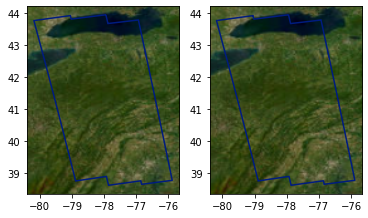

In [13]:
#Lets double check the aoi 
geo_bbox = gpd.read_file(prods_TOTbbox)
geo_bbox1 = gpd.read_file(prods_TOTbbox_metadatalyr)

fig, ax = plt.subplots(1,2)
geo_bbox.exterior.plot(ax=ax[0])
geo_bbox1.exterior.plot(ax=ax[1])

parms = dict(zoom=5, source=cx.providers.Esri.WorldImagery, crs=CRS.from_epsg(4326), zorder=0,attribution=False)
cx.add_basemap(ax[0], **parms)
cx.add_basemap(ax[1], **parms)

In [14]:
dem_filename = path_wd.parent / f'DEM{small}' / 'glo_90.dem'

if  dem_filename.exists():
    dem_option = str(dem_filename)
else:
    dem_option = 'download'
    
# Overwrite
#dem_option = 'download' # Uncomment if you want to skip Downloading

# Download/Load DEM & Lat/Lon arrays, providing bbox,
# expected DEM shape, and output dir as input.
dem, demfile, Latitude, Longitude = prep_dem(
            dem_option, bbox_file,
            prods_TOTbbox, prods_TOTbbox_metadatalyr, proj,
            arrres=arrres, workdir=str(path_wd),
            outputFormat='ISCE', num_threads=10)

dem_extent = ds_get_extent(demfile)
dem_extent

Applied cutline to produce 3 arc-sec Copernicus GLO90 DEM: /u/leffe-data2/buzzanga/data/VLM/RAiDER_Tests/aria_export_dask/dask_test_small/DEM/glo_90.dem


[-80.18663459200009, -75.88163631400009, 38.62915121499995, 43.93248242699995]

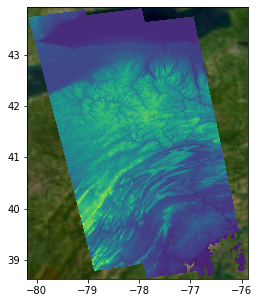

In [15]:
fig, ax = plt.subplots(figsize=(8,5))
ax.imshow(np.ma.masked_equal(demfile.ReadAsArray(),0), extent=dem_extent, zorder=1)
cx.add_basemap(ax, zoom=5, source=cx.providers.Esri.WorldImagery, crs=CRS.from_epsg(4326), zorder=0, attribution=False)

In [ ]:
%%time
# Prepare mask
amplitude_products = []
for d in product_dict:
    if 'amplitude' in d:
        for item in list(set(d['amplitude'])):
            amplitude_products.append(item)


mask_filename = path_wd / 'mask/watermask.msk'

if  mask_filename.exists():
    mask_option = 'mask/' + mask_filename.name
    mask = gdal.Open(mask_filename)
else:
    mask_option = 'download'
    # Running pre_mask overwrites the current one and 
    # generates all nan file
    mask = prep_mask(amplitude_products,
                    mask_option,
                    bbox_file,
                    prods_TOTbbox, proj, 
                    amp_thresh=None,
                    arrres=arrres,
                    workdir=path_wd,
                    outputFormat='ISCE',
                    num_threads=10)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(8,5))
ax[0].imshow(np.ma.masked_equal(demfile.ReadAsArray(),0),
             extent=dem_extent, zorder=1)
ax[0].set_ylim([33, 44])
cx.add_basemap(ax[0], zoom=5, source=cx.providers.Esri.WorldImagery,
               crs=CRS.from_epsg(4326), zorder=0)

mask_extent = ds_get_extent(mask)
ax[1].imshow(np.ma.masked_equal(mask.ReadAsArray(),0),
             extent=mask_extent, zorder=1)
ax[1].set_ylim([33, 44])
cx.add_basemap(ax[1], zoom=5, source=cx.providers.Esri.WorldImagery,
               crs=CRS.from_epsg(4326), zorder=0)

# Export using Dask

## UnwrappedPhase and Connected Components

In [ ]:
mask.GetDescription()

In [ ]:
%%time
exportUnwrappedPhase(product_dict, 
                      bbox_file,
                      prods_TOTbbox, arrres, path_wd,
                      mask_zero_component=False,
#                       mask=mask.GetDescription(), n_jobs=30)
                      mask=None, n_jobs=5)

## Coherence

In [ ]:
%%time
exportCoherenceAmplitude(product_dict, 
                         bbox_file,
                         prods_TOTbbox, arrres, path_wd, 
                         #mask=mask.GetDescription(), n_threads=10, n_jobs=30)
                         mask=None, n_jobs=1)

exportCoherenceAmplitude(product_dict, 
                         bbox_file,
                         prods_TOTbbox, arrres, path_wd, layer='amplitude',
                         #mask=mask.GetDescription(), n_threads=10, n_jobs=30)
                         mask=None, n_jobs=1)

## Imaging Geometry

- ***'/science/grids/imagingGeometry/perpendicularBaseline'***
- '/science/grids/imagingGeometry/parallelBaseline'
- ***'/science/grids/imagingGeometry/incidenceAngle'***
- '/science/grids/imagingGeometry/lookAngle'
- ***'/science/grids/imagingGeometry/azimuthAngle'***

 Export only first scene for Incidence and Azimuth Angle

In [ ]:
%%time
## Take a lot of RAM memory per worker, 9GB per scene
## Dask reports leak - functions need restructuring
exportImagingGeometry(product_dict[:1], 
                      bbox_file, 
                      prods_TOTbbox, 
                      demfile, Latitude, Longitude, 
                      path_wd, layer='incidenceAngle', 
#                       mask=mask.GetDescription(), 
                      mask=None, 

                      n_threads=1, n_jobs=1)

In [ ]:
%%time
## Take a lot of RAM memory per worker, 9GB per scene
## Dask reports leak - functions need restructuring
exportImagingGeometry(product_dict[:1], 
                      bbox_file, 
                      prods_TOTbbox, 
                      demfile, Latitude, Longitude, 
                      path_wd, layer='azimuthAngle', 
#                       mask=mask.GetDescription(), 
                      mask=None, 
                      n_threads=1, n_jobs=1)

In [ ]:
%%time
## Take a lot of RAM memory per worker, 9GB per scene
## Dask reports leak - functions need restructuring
max_jobs = len(product_dict)
n_jobs   = 20

# Workaround solution
for n in range(0, max_jobs, n_jobs):
    if n + n_jobs > len(product_dict):
        print('Loop:', [n, max_jobs])
        product_subset = product_dict[n:max_jobs]
    else:
        print('Loop:', [n, n + n_jobs])
        product_subset = product_dict[n:n+n_jobs]

    exportImagingGeometry(product_subset,
                          bbox_file,
                          prods_TOTbbox,
                          demfile, Latitude, Longitude,
                          path_wd, layer='bPerpendicular',
#                           mask=mask.GetDescription(),
                          mask=None,
                          n_threads=5, n_jobs=n_jobs)

## Corrections Layers
- ***'/science/grids/corrections/external/troposphere/HRRR/reference'***
- '/science/grids/corrections/external/troposphere/HRRR/secondary'

- ***'/science/grids/corrections/external/tides/solidEarth/reference'***
- '/science/grids/corrections/external/tides/solidEarth/secondary'

In [16]:
len(product_dict)

2

In [17]:
%%time
%pdb off
exportTropo(product_dict, bbox_file, prods_TOTbbox,
                      demfile, Latitude, Longitude, 
                      path_wd, layer='troposphereWet', 
                      mask=None, 
                      wmodel='HRRR', 
                      n_threads=2, n_jobs=2, debug=False)

Automatic pdb calling has been turned OFF
Running GUNW troposphereWet in parallel!


/u/leffe-data2/buzzanga/Miniconda3/envs/ARIA/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43980 instead
  warnings.warn(


Link: http://127.0.0.1:43980/status
Run 2 reference jobs with 2 workers.
Catching breath...
Run 2 secondary jobs with 2 workers.
Finalizing reference: /u/leffe-data2/buzzanga/data/VLM/RAiDER_Tests/aria_export_dask/dask_test_small/troposphereWet/20230807_20230714/HRRR/dates/20230807
Finalizing secondary: /u/leffe-data2/buzzanga/data/VLM/RAiDER_Tests/aria_export_dask/dask_test_small/troposphereWet/20230807_20230714/HRRR/dates/20230714
Finalizing reference: /u/leffe-data2/buzzanga/data/VLM/RAiDER_Tests/aria_export_dask/dask_test_small/troposphereWet/20230714_20230608/HRRR/dates/20230714
Finalizing secondary: /u/leffe-data2/buzzanga/data/VLM/RAiDER_Tests/aria_export_dask/dask_test_small/troposphereWet/20230714_20230608/HRRR/dates/20230608
CPU times: user 6.16 s, sys: 8.67 s, total: 14.8 s
Wall time: 1min 17s


In [18]:
%%time
%pdb off
exportTropo(product_dict, bbox_file, prods_TOTbbox,
                      demfile, Latitude, Longitude, 
                      path_wd, layer='troposphereHydrostatic', 
                      mask=None, 
                      wmodel='HRRR', 
                      n_threads=2, n_jobs=2, debug=False)

Automatic pdb calling has been turned OFF
Running GUNW troposphereHydrostatic in parallel!


/u/leffe-data2/buzzanga/Miniconda3/envs/ARIA/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46552 instead
  warnings.warn(


Link: http://127.0.0.1:46552/status
Run 2 reference jobs with 2 workers.
Catching breath...
Run 2 secondary jobs with 2 workers.
Finalizing reference: /u/leffe-data2/buzzanga/data/VLM/RAiDER_Tests/aria_export_dask/dask_test_small/troposphereHydrostatic/20230714_20230608/HRRR/dates/20230714
Finalizing secondary: /u/leffe-data2/buzzanga/data/VLM/RAiDER_Tests/aria_export_dask/dask_test_small/troposphereHydrostatic/20230714_20230608/HRRR/dates/20230608
Finalizing reference: /u/leffe-data2/buzzanga/data/VLM/RAiDER_Tests/aria_export_dask/dask_test_small/troposphereHydrostatic/20230807_20230714/HRRR/dates/20230807
Finalizing secondary: /u/leffe-data2/buzzanga/data/VLM/RAiDER_Tests/aria_export_dask/dask_test_small/troposphereHydrostatic/20230807_20230714/HRRR/dates/20230714
CPU times: user 5.42 s, sys: 8.68 s, total: 14.1 s
Wall time: 1min 15s


In [19]:
wm    = 'HRRR'
ifgs  = [op.splitext(op.basename(prod['productBoundingBox'][0]))[0] for prod in  product_dict]
move_tropo_layers(path_wd, ifgs, wm)
compute_tropo_total(path_wd, wm)

Moved paths to correct directories
Wrote troposphereTotal for 3 dates.


## Generate Stacks

In [ ]:
from ARIAtools.ARIA_global_variables import ARIA_STACK_OUTFILES, ARIA_STACK_DEFAULTS

In [ ]:
ref_dlist = generate_stack(standardproduct_info, 'unwrappedPhase',
                               'unwrapStack', workdir=path_wd)

ref_dlist = generate_stack(standardproduct_info, 'connectedComponents',
                               'conncompStack', workdir=path_wd)

ref_dlist = generate_stack(standardproduct_info, 'coherence',
                               'cohStack', workdir=path_wd)


ref_dlist = generate_stack(standardproduct_info, 'amplitude',
                               'ampStack', workdir=path_wd)

In [ ]:
ref_dlist = generate_stack(standardproduct_info, 'HRRR', f'{wm}Stack', path_wd, 
                           ref_tropokey='troposphereTotal')

## Compare against nonDask results

In [20]:
import rioxarray as xrr

In [23]:
path_non  = Path(f'{path_wd.parent}/nondask_test{small}_complete')
path_dask = Path(f'{path_wd.parent}/dask_test{small}')
# ifg       = '20230807_20230714'
# ifg       = 'dates/20230807' # this one looks good
ifg       = 'dates/20230714' # if i use the first ifg, this is incorrect
# ifg       = 'dates/20230608' # if i use the first ifg this is fine

In [ ]:
# ifgs
layers0 = 'unwrappedPhase coherence connectedComponents amplitude'.split()
layers1 = 'bPerpendicular bParallel lookAngle azimuthAngle incidenceAngle'.split()

# choose layer here
layer   = layers0[0]

path_unw_d = op.join(path_dask, layer, ifg)
da_d   = xrr.open_rasterio(path_unw_d, band_as_variable=True)['band_1'].rename(layer)

path_unw_n = op.join(path_non, layer, ifg)
da_n   = xrr.open_rasterio(path_unw_n, band_as_variable=True)['band_1'].rename(layer)

da_resid = da_d.copy()
da_resid.data = da_n.data - da_d.data

fig, axes = plt.subplots(figsize=(16, 6), ncols=3, sharey=True)

da_n.plot(ax=axes[0])
da_d.plot(ax=axes[1])
da_resid.plot(ax=axes[2], cmap='cmc.broc')
axes[0].set_title('NonDask')
axes[1].set_title('Dask')
axes[2].set_title('Residual (NonDask-Dask)')

for ax in axes:
    ax.set_ylabel('')
    ax.set_xlabel('')

print (f'Residual Mean: {da_resid.mean():.2f} +/- {da_resid.std():.2f}')
print (f'Residual Min|Max: {da_resid.min():.2f} | {da_resid.max():.2f}')

Residual Mean: -0.00 +/- 0.00
Residual Min|Max: -0.00 | 0.00


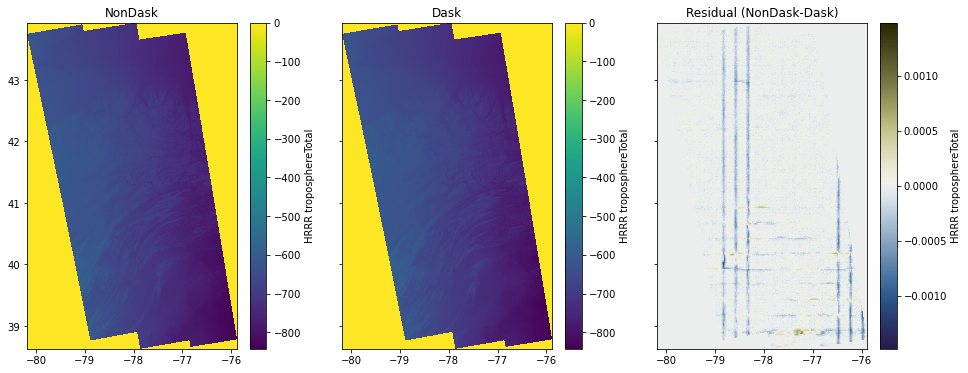

In [30]:
# tropo 
wm     = 'HRRR'

layers = 'troposphereWet troposphereHydrostatic troposphereTotal'.split()
layer  = layers[2] # choose layer

# path_d = op.join(path_dask, layer, '20230714_20230608', wm, ifg) # prior to moving
path_d = op.join(path_dask, layer, wm, ifg)

da_d   = xrr.open_rasterio(path_d, band_as_variable=True)['band_1'].rename(f'{wm} {layer}')

path_n = op.join(path_non, layer, wm, ifg)
da_n   = xrr.open_rasterio(path_n, band_as_variable=True)['band_1'].rename(f'{wm} {layer}')


da_resid = da_d.copy()
da_resid.data = da_n.data - da_d.data

fig, axes = plt.subplots(figsize=(16, 6), ncols=3, sharey=True)

da_n.plot(ax=axes[0])
da_d.plot(ax=axes[1])
da_resid.plot(ax=axes[2], cmap='cmc.broc')
axes[0].set_title('NonDask')
axes[1].set_title('Dask')
axes[2].set_title('Residual (NonDask-Dask)')


for ax in axes:
    ax.set_ylabel('')
    ax.set_xlabel('')

print (f'Residual Mean: {da_resid.mean().item():.2f} +/- {da_resid.std().item():.2f}')
print (f'Residual Min|Max: {da_resid.min().item():.2f} | {da_resid.max().item():.2f}')

# plt.close()